# Face sticker camera

## Face image 준비

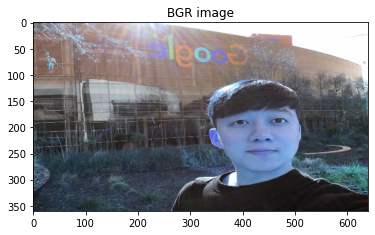

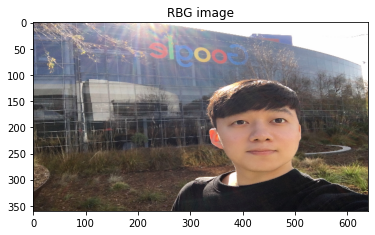

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

my_image_path = '/content/drive/MyDrive/AIFFEL/Exploration/camera_sticker/images/jaewoong_1.jpg'
img_bgr = cv2.imread(my_image_path)         # OpenCV로 이미지를 읽어서 
img_bgr = cv2.resize(img_bgr, (640, 360))   # 640x360의 VGA 크기(16:9)로 Resize
img_show = img_bgr.copy()                   # 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.title('BGR image')
plt.show() # BGR(Blue, Green, Red)순으로 색 바뀜

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # Convert BGR to RBG
plt.imshow(img_rgb)
plt.title('RBG image')
plt.show()

## Face detection

얼굴의 bounding box 위치: rectangles[[(368, 153) (497, 282)]]


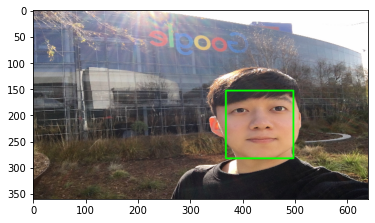

In [2]:
import dlib
detector_hog = dlib.get_frontal_face_detector()
# dlib은 RGB 이미지를 입력으로 받으므로, Convert BGR to RBG
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1) # (img, num of pyramid) 에서 피라미드 수?
# => 이미지를 upsampling 방법을 통해 크기를 키우는 것 (크게보면 더 정확한 검출 가능)

print('얼굴의 bounding box 위치:', dlib_rects) # dlib.rectangles 는 dlib.rectangle 객체의 배열 형태
# dlib.rectangle 객체는 left(), top(), right(), bottom(), height(), width() 등 멤버 함수 포함
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## Face landmark

- **Object keypoint estimation 알고리즘**
    - Face landmark와 같이 객체 내부의 점을 찾는 기술
    - keypoint를 찾는 알고리즘은 크게 2가지
        - 1) top-down : bounding box를 찾고 box 내부의 keypoint 예측
        - 2) bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성
- Dlib landmark localization
    - 잘라진 얼굴 이미지에서 아래 68개의 이목구비 위치를 찾음 (점의 개수는 논문 마다 상이)

The number of total points is 68


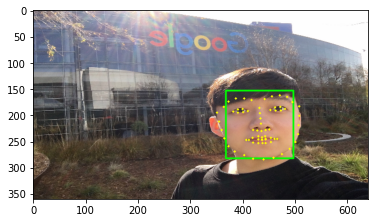

In [3]:
import os
model_path = '/content/drive/MyDrive/AIFFEL/Exploration/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path) # landmark 모델 불러서

list_landmarks = []
for dlib_rect in dlib_rects:
    # RGB 이미지와 dlib.rectangle을 입력받아 dlib.full_object_detection 반환
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print('The number of total points is', len(list_landmarks[0]))

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## Sticker 적용

- 고양이 수염이 적용 될 볼 위치를 계산하기 위해 landmark 사용    
    - x_position = 코위치(30)
    - y_position = 턱(2), 눈(36), 입(48), 코(30) 중앙 위치

1. 스티커 위치   
$ x = x_{nose} $   
$ y = avg(y_{chinL}, y_{eyesL}, y_{mouthL}, y_{nose})$
2. 스티커 크기   
$ width = height = width_{bbox} $ 


In [4]:
# 좌표 확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30])
    x = landmark[30][0]
    y = (landmark[2][1]+landmark[36][1]+landmark[48][1]+landmark[30][1])//4
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(435, 216)
(x,y) : (435,221)
(w,h) : (130,130)


(130, 130, 3)
(x,y) : (370,156)


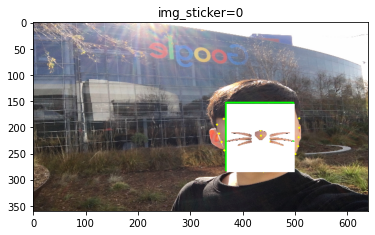

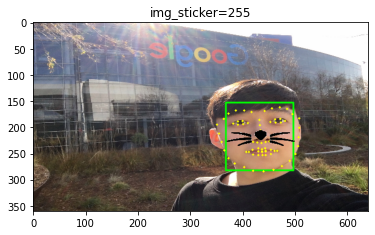

In [5]:
import os
sticker_path = '/content/drive/MyDrive/AIFFEL/Exploration/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) # 준비해둔 스티커 이미지
img_sticker = cv2.resize(img_sticker, (w,h)) # 윗 단계에서 계산한 크기로 resize 
print (img_sticker.shape)

# x,y좌표 지정, 이미지 시작점은 top-left
refined_x = x - w // 2  # left
refined_y = y - h // 2  # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# 이미지에서 얼굴이 위쪽에 있으면 시작점 y좌표가 음수가 될 수 있음
# ndarray는 음수 인덱스에 접근할 수 없기 때문에 음수에 대한 예외 처리 필요
# 원본 이미지 범위 벗어난 부분 제거 (-y 크기만큼 스티커를 crop)
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:]
    print (img_sticker.shape)

    refined_y = 0 # top 의 y 좌표는 원본 이미지의 경계 값으로 수정
    print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

img_tmp = img_show.copy()
sticker_area = img_tmp[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_tmp[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_tmp, cv2.COLOR_BGR2RGB))
plt.title('img_sticker=0')
plt.show()

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
    # np.where를 통해 img_sticker 가 0 인 부분은 sticker_area를 사용하고
    # 0이 아닌 부분을 img_sticker를 사용
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.title('img_sticker=255')
plt.show()

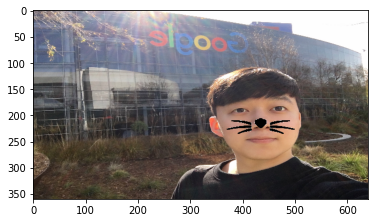

In [6]:
# bounding box와 landmark를 제거
img_bgr_tmp=img_bgr.copy()
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_rgb 사용
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## Image blending

- 스티커를 좀 더 자연스럽게 적용해보자 (opencv 의 cv2.addWeighted() 참고)

    - Image blending
        - 두개의 이미지에 각각의 가중치를 두고 합하는 방법
        - 가중치 값이 더 큰 이미지가 좀 더 선명하게 나타남
        - Theory   
            - $ g(x) = (1-\alpha)f_0(x) + \alpha f_1(x) $
            - $\alpha$ from 0 → 1 일 때 영상에서 사용하는 화면 전환(cross-dissolve)처럼 연출 가능
        - cv2.addWeighted(src1, alpha, src2, beta, gamma[, dst[, dtype]]) -> dst    

|Params|||||||
|:----:|:----:|:----:|:----:|:----:|:----:|:----:|
|src1|alpha|src2|beta|gamma|dst|dtype|
|이미지1|이미지1 가중치|이미지2|이미지2 가중치|각 덧셈에 추가하는 값|결과 이미지|depth|

$ $

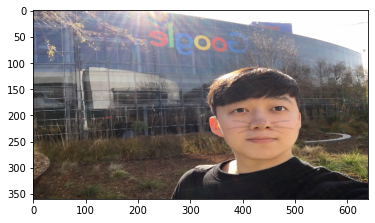

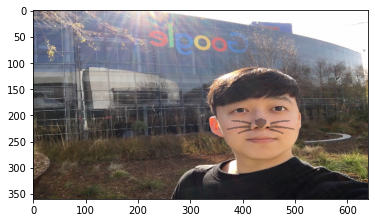

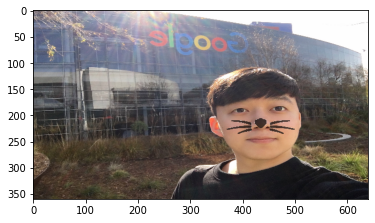

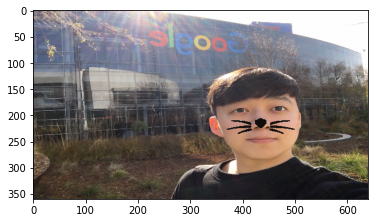

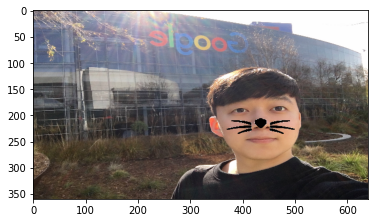

In [7]:
import time
# bounding box와 landmark를 제거
sticker_area = img_bgr_tmp[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
tmp_sticker = np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
fig = plt.figure()
img_list = []
for alpha in np.arange(0.1, 1, 0.2, dtype=np.float32)[::-1]:
    plt.cla()
    beta = 1-alpha
    dst_sticker = cv2.addWeighted(sticker_area, alpha, tmp_sticker, beta, 0)
    img_bgr_tmp[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = dst_sticker
    plt.imshow(cv2.cvtColor(img_bgr_tmp, cv2.COLOR_BGR2RGB))
    img_list.append(cv2.cvtColor(img_bgr_tmp, cv2.COLOR_BGR2RGB))
    plt.show()

## 다양한 사진에 적용

====================== rdj_1.jpg ======================
얼굴의 bounding box 위치: rectangles[[(200, 23) (468, 290)]]


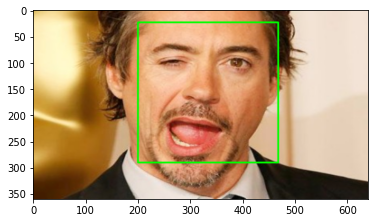

The number of landmarks is 68


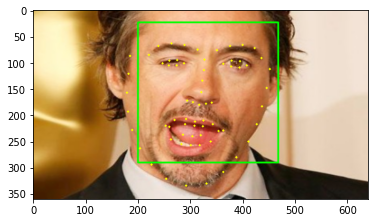

(317, 180)
(x,y) : (317,158)
(w,h) : (269,269)
(269, 269, 3)
(x,y) : (183,24)


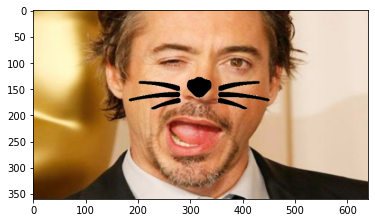



====================== rdj_2.jpg ======================
얼굴의 bounding box 위치: rectangles[[(268, 67) (397, 196)]]


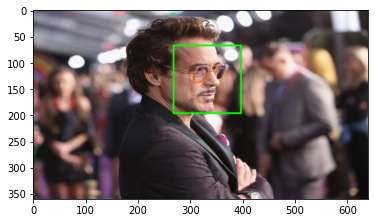

The number of landmarks is 68


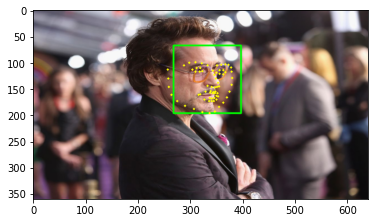

(347, 147)
(x,y) : (347,139)
(w,h) : (130,130)
(130, 130, 3)
(x,y) : (282,74)


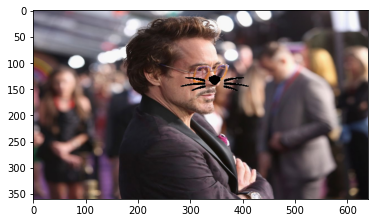



====================== rdj_3.jpg ======================
얼굴의 bounding box 위치: rectangles[[(394, 55) (446, 107)]]


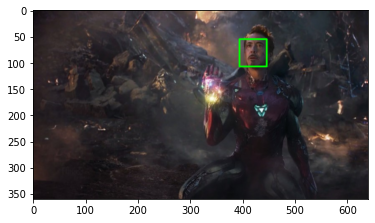

The number of landmarks is 68


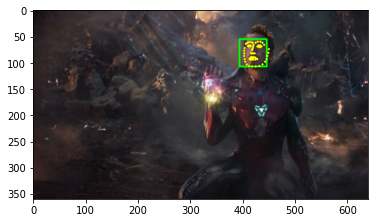

(419, 82)
(x,y) : (419,79)
(w,h) : (53,53)
(53, 53, 3)
(x,y) : (393,53)


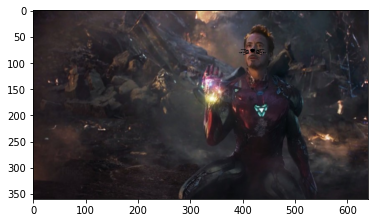



====================== rdj_4.jpg ======================
얼굴의 bounding box 위치: rectangles[[(235, 56) (325, 146)]]


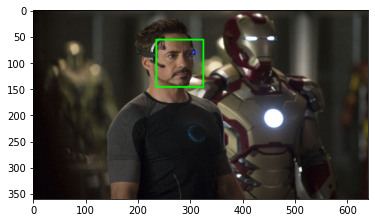

The number of landmarks is 68


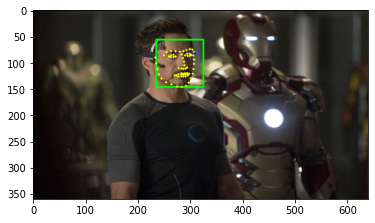

(287, 112)
(x,y) : (287,107)
(w,h) : (91,91)
(91, 91, 3)
(x,y) : (242,62)


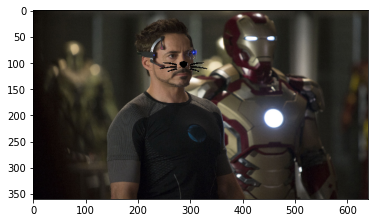



====================== rdj_5.jpeg ======================
얼굴의 bounding box 위치: rectangles[]


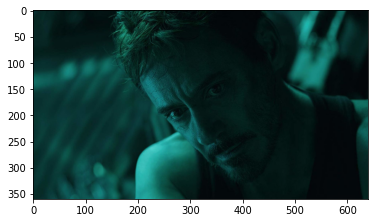

IndexError: ignored

In [8]:
import cv2, os, dlib
import matplotlib.pyplot as plt
import numpy as np

base_dir = r"/content/drive/MyDrive/AIFFEL/Exploration/camera_sticker/images/img_rdj"
img_files = [x for x in os.listdir('/content/drive/MyDrive/AIFFEL/Exploration/camera_sticker/images/img_rdj')]
img_files.sort()

def camera_sticker(my_image_path):
    img_bgr = cv2.imread(my_image_path)    
    img_bgr = cv2.resize(img_bgr, (640, 360))   
    img_show = img_bgr.copy()                  

    detector_hog = dlib.get_frontal_face_detector()
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    dlib_rects = detector_hog(img_rgb, 1) 
    print('얼굴의 bounding box 위치:', dlib_rects)  

    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

    img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    plt.imshow(img_show_rgb)
    plt.show()

    model_path = '/content/drive/MyDrive/AIFFEL/Exploration/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path) 

    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect) 
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    print('The number of landmarks is', len(list_landmarks[0]))

    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img_show, point, 2, (0, 255, 255), -1) 

    img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    plt.imshow(img_show_rgb)
    plt.show()

    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        print (landmark[33])
        x = landmark[33][0]
        y = (landmark[2][1]+landmark[36][1]+landmark[48][1]+landmark[30][1])//4
        w = dlib_rect.width()
        h = dlib_rect.width()
        print ('(x,y) : (%d,%d)'%(x,y))
        print ('(w,h) : (%d,%d)'%(w,h))

    sticker_path = '/content/drive/MyDrive/AIFFEL/Exploration/camera_sticker/images/cat-whiskers.png'
    img_sticker = cv2.imread(sticker_path)
    img_sticker = cv2.resize(img_sticker, (w,h))
    print (img_sticker.shape)

    refined_x = x - w // 2 
    refined_y = y - h // 2
    print ('(x,y) : (%d,%d)'%(refined_x, refined_y))
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:]
        print (img_sticker.shape)

        refined_y = 0 
        print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

    sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.show()

for img_file in img_files:
    print(f'====================== {img_file} ======================')
    camera_sticker(base_dir+'/'+img_file)
    print('\n')

## Sticker 적용 시 문제점

- img_sticker 값에 처음 선택한 0이 아닌 왜 255로 선택 해야할까?
- img_sticker 값이 0에 해당하는 부분이 배경이 아니라 수염부분임을 아래에서 확인 가능
- np.where(값이 일치는 부분에는, sticker_area를 사용하고, 일치하지 않는 부분은 img_sticker 사용)

In [9]:
np.unique(img_sticker, return_counts = True) 

(array([  0,   1,   3,   6,   7,  10,  22,  26,  41,  45,  48,  54,  57,
         60,  61,  73, 120, 135, 136, 144, 147, 151, 164, 167, 171, 172,
        175, 181, 184, 185, 186, 189, 197, 198, 202, 205, 212, 214, 218,
        229, 233, 234, 241, 244, 245, 247, 248, 249, 251, 253, 255],
       dtype=uint8),
 array([ 3264,     6,     6,    18,     3,     6,     6,     6,     6,
            6,     6,    12,    18,     6,     6,    63,    12,     6,
            3,     6,    18,     6,     6,     6,    12,     6,     6,
            6,     6,     6,    12,     9,     6,    24,    18,     6,
            6,     6,    30,     6,    12,     6,     6,     3,    12,
            9,    18,     9,     6,     9, 46944]))

## 결론

- sticker 적용 시 배경과 스티커 부분의 color 값 확인 필요
- 다양한 이미지에 적용한 결과를 보면, 약간의 옆모습까지는 detection 단계에서 무리가 없음
- 하지만 `rdj_5.jpg` 처럼 어둡고, 얼굴의 색상 차이가 심한 이미지에 대해서는 face detection에 무리가 있음.
- 얼굴 각도 또한 영향이 있다고 판단됨